# CAPSTONE
## Battle of the Neighborhoods
### __Italian Restaurants__
_Nicholas Sloot_

### -------------------------------------------------------------------------------------------------------

#### __Introduction__
This final project explores the best locations for Italian restaurants throughout the city of New York. Food Business News stated that worldwide pasta sales were up for the second year in a row with the United Sates holding the largest market (Donley, 2018).  New York is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. Most of the Italian immigration into the United States occurred during the late 19th and early 20th century with over two million immigrants between 1900 and 1910.  Italian families first settled in Little Italy’s neighborhood around Mulberry Street as has continued to thrive ever since.  With almost 700,000 Manhattan inhabitants reporting Italian ancestry, the need to find and enjoy Italian cuisine is on the rise.  This report explores which neighborhoods and boroughs of New York City have the most as well as the best Italian restaurants. Additionally, I will attempt to answer the questions “Where should I open an Italian Restaurant?” and “Where should I stay If I want great Italian food?”

### __Data__
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.



### __Methodology__
•	Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

•	FourSquare be used to locate all venues and then filtered by Italian restaurants.  Ratings, tips, and likes by users will be counted and added to the dataframe.

•	Data will be sorted based on rankings

•	Finally, the data be will be visually assessed using graphing from various Python libraries.

### __Problem Statement__
1.	What is / are the best location(s) for Italian cuisine in New York City?
2.	In what Neighborhood and/or borough should I open an Italian restaurant to have the best chance of being successful?
3.	Where would I go in New York City to have the best Italian food?

Load Libraries

In [32]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


My variables

In [2]:
# The code was removed by Watson Studio for sharing.

Functions that will be used later

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Now lets use the above codes to get our initial NYC data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five buroughs. 

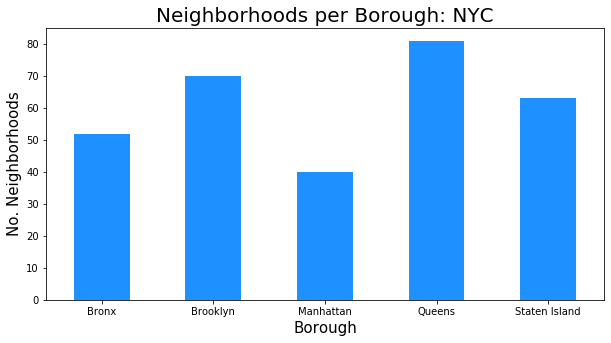

In [6]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Lets analyze further and see how many italian restaurants there are in each neighborhood and burough and graph the results.

In [24]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

In [20]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [7]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
238,Queens,Sunnyside Gardens,5699aa86498ef437b2fd7102,Zio Luigi
239,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
240,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
241,Staten Island,Prince's Bay,4c091311a1b32d7f5efb96f0,Certo's Gourmet Foods & Caterers
242,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [8]:
italian_rest_ny.shape

(243, 4)

As we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the highest number if Italian restaurants.  Additionally, we see how many restaurants the top 6 neighborhoods have.  The neighborhood of Belmont has the highest number of Italian restaurants in all of NYC and is actually located in the burough of Bronx vice Manhattan.

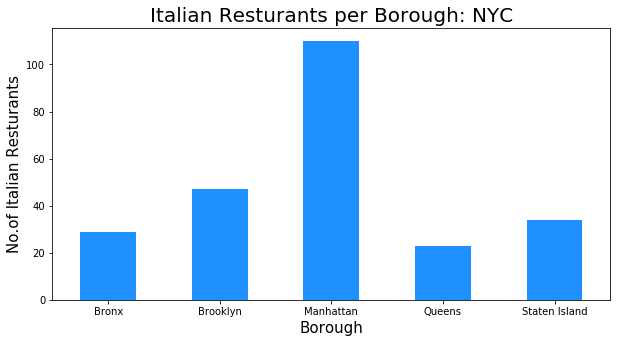

In [9]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

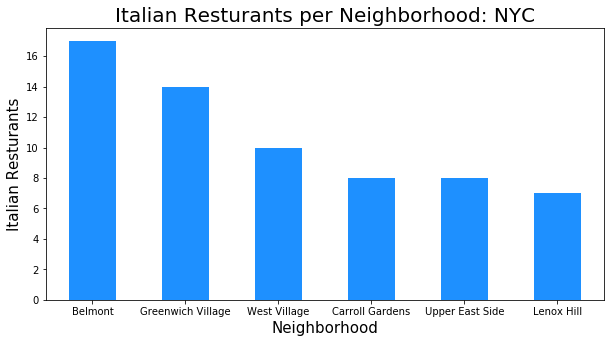

In [10]:
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [11]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
5,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
6,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
7,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
8,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
9,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
10,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
11,Bronx,Belmont,4c9b9e7b9c663704b90463fd,Gerbasi Ristorante
12,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
13,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
14,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering


In [12]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5d80dad5396de0003967418e'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http:

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
238,Queens,Sunnyside Gardens,5699aa86498ef437b2fd7102,Zio Luigi,8,7.0,3
239,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's,313,8.9,67
240,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's,313,8.9,67
241,Staten Island,Prince's Bay,0,0,0,0.0,0
242,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde,7,7.6,3


In [44]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [45]:
italian_rest_stats_ny.shape

(243, 7)

In [46]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 7 columns):
Borough         243 non-null object
Neighborhood    243 non-null object
ID              243 non-null object
Name            243 non-null object
Likes           243 non-null float64
Rating          243 non-null float64
Tips            243 non-null float64
dtypes: float64(3), object(4)
memory usage: 13.4+ KB


In [47]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 7 columns):
Borough         243 non-null object
Neighborhood    243 non-null object
ID              243 non-null object
Name            243 non-null object
Likes           243 non-null float64
Rating          243 non-null float64
Tips            243 non-null float64
dtypes: float64(3), object(4)
memory usage: 13.4+ KB


In [48]:
italian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,243.000000,243.000000,243.000000
mean,130.226337,7.482305,53.049383
std,233.410791,2.120301,107.324860
min,0.000000,0.000000,0.000000
25%,15.000000,7.500000,7.000000
50%,39.000000,8.000000,18.000000
75%,116.500000,8.600000,51.500000
max,1431.000000,9.400000,1136.000000


In [18]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4afb2990f964a520a91b22e3
Name                            Maialino
Likes                               1431
Rating                               9.1
Tips                                 464
Name: 148, dtype: object

In [19]:
# Resturant with maximum Ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              5a00f3538496ca58fd9e2856
Name                  Evelina Restaurant
Likes                                165
Rating                               9.4
Tips                                  33
Name: 52, dtype: object

In [20]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 20
Rating                               8.4
Tips                                1136
Name: 176, dtype: object

In [49]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
86,Tribeca,9.200000
11,Boerum Hill,9.200000
12,Bushwick,9.200000
44,Hamilton Heights,9.000000
37,Fulton Ferry,8.900000
54,Lower East Side,8.900000
28,Dumbo,8.900000
64,Noho,8.766667
43,Greenwich Village,8.707143
80,Soho,8.700000


In [50]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.336364
0,Bronx,7.817241
1,Brooklyn,7.365957
3,Queens,7.021739
4,Staten Island,4.905882


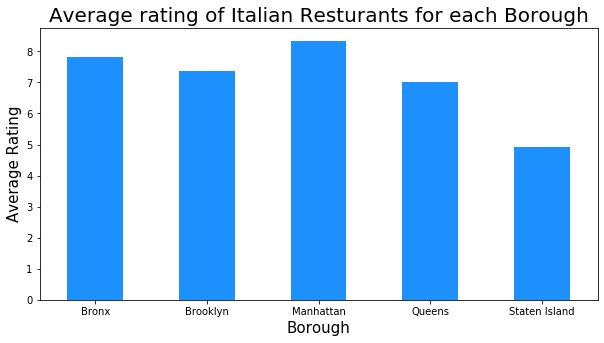

In [51]:
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [52]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Auburndale,8.100000
4,Battery Park City,8.100000
11,Boerum Hill,9.200000
12,Bushwick,9.200000
13,Carnegie Hill,8.150000
16,Chinatown,8.200000
17,City Island,8.200000
18,Civic Center,8.033333
19,Clinton,8.033333
20,Clinton Hill,8.500000


In [53]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Auburndale,40.761730,-73.791762,8.100000
1,Manhattan,Battery Park City,40.711932,-74.016869,8.100000
2,Brooklyn,Boerum Hill,40.685683,-73.983748,9.200000
3,Brooklyn,Bushwick,40.698116,-73.925258,9.200000
4,Manhattan,Carnegie Hill,40.782683,-73.953256,8.150000
5,Manhattan,Chinatown,40.715618,-73.994279,8.200000
6,Bronx,City Island,40.847247,-73.786488,8.200000
7,Manhattan,Civic Center,40.715229,-74.005415,8.033333
8,Manhattan,Clinton,40.759101,-73.996119,8.033333
9,Brooklyn,Clinton Hill,40.693229,-73.967843,8.500000


In [54]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [55]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [30]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

Finally, we will visualize all NYC buroughs based on average Rating.

In [62]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

### __Results / Conclusion__
Manhattan and Queens have the best rated Italian restaurants on average. Queens and The Bronx have the least amount of Italian restaurants per burough. However, of note, Belmont of The Bronx is the neighborhood in all of NYC with the most Italian Restaurants. Despite Manhattan having the least number of neighborhoods in all five buroughs, it has the most Italian restaurants.  Based on this information, I would state that Manhattan and Queens are the best locations for Italian cruisine in NYC. To have the best shot of success, I would open an Italian restaurants in Queens. Queens has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of Italian restaurants making competition easier than in other buroughs. Finally, I would go to Gramercy in Manhattan for the best Italian food based on 131 likes. As a final note, all of the above analysis is depended  on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.